### Modeling Setup 

Goal: Build and compare multiple classification models to predict track popularity levels based on key audio features.

Algorithms Implemented: 
- Decision Tree Classifier (Gini & Entropy)
- Random Forest Classifier  
- Bagging Classifier
- Logistic Regression
- Hyperparamater Tuning (Random Forest)  

Evaluation Metrics:  
- Accuracy  
- Precision  
- Recall  
- F1 Score (macro)  
- Confusion Matrix  

Final Criteria: 
The best model was chosen based on a balance between predictive performance (F1 score), robustness to noise, generalization to test data, and scalability.  

In [303]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer

In [305]:
X_train = pd.read_csv("X_train.csv", index_col=0)
X_test = pd.read_csv("X_test.csv", index_col=0)
y_train = pd.read_csv("y_train.csv").squeeze()
y_test = pd.read_csv("y_test.csv").squeeze()

In [307]:
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test[X_train.columns]

In [309]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed_array = imputer.fit_transform(X_train_numeric)
X_test_imputed_array = imputer.transform(X_test_numeric)

X_train_imputed = pd.DataFrame(X_train_imputed_array, columns=X_train_numeric.columns)
X_test_imputed = pd.DataFrame(X_test_imputed_array, columns=X_train_numeric.columns)

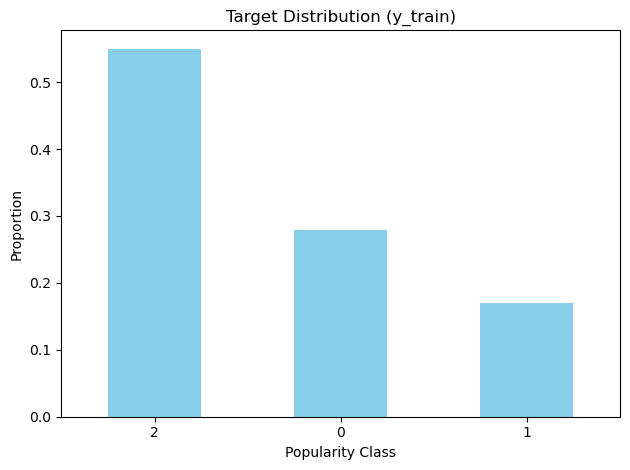

In [343]:
y_train.value_counts(normalize=True).plot(kind='bar', title='Target Distribution (y_train)', color='skyblue')
plt.xlabel("Popularity Class")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In this bar graph, I was to get a clear view of ohow track popularity is distributed in my training data. Most tracks fall into Class 2, which represents the most popular songs. Class 0 (less popular) make up a decent portion, but Class 1 (moderatley popular) is less frequient. This class imbalance insight highlights the importance of using evaluation metrics like macro F1 score to ensure fair model performance across all classes.

In [349]:
# Decision Tree (GINI)
dt_gini = DecisionTreeClassifier(criterion='gini', random_state=42)
dt_gini.fit(X_train, y_train)
y_pred_gini = dt_gini.predict(X_test)
print("\n Decision Tree (Gini):\n", classification_report(y_test, y_pred_gini))


 Decision Tree (Gini):
               precision    recall  f1-score   support

           0       0.84      0.80      0.82        88
           1       0.48      0.51      0.50        53
           2       0.78      0.79      0.79       172

    accuracy                           0.74       313
   macro avg       0.70      0.70      0.70       313
weighted avg       0.75      0.74      0.75       313



In [351]:
# Decision Tree (ENTROPY)
dt_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_entropy.fit(X_train, y_train)
y_pred_entropy = dt_entropy.predict(X_test)
print("\n Decision Tree (Entropy):\n", classification_report(y_test, y_pred_entropy))


 Decision Tree (Entropy):
               precision    recall  f1-score   support

           0       0.81      0.77      0.79        88
           1       0.53      0.49      0.51        53
           2       0.76      0.80      0.78       172

    accuracy                           0.74       313
   macro avg       0.70      0.69      0.69       313
weighted avg       0.74      0.74      0.74       313



In [353]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("\n Random Forest:\n", classification_report(y_test, y_pred_rf))


 Random Forest:
               precision    recall  f1-score   support

           0       0.93      0.76      0.84        88
           1       0.72      0.34      0.46        53
           2       0.75      0.94      0.83       172

    accuracy                           0.79       313
   macro avg       0.80      0.68      0.71       313
weighted avg       0.79      0.79      0.77       313



In [355]:
# Bagging Classifier
bag = BaggingClassifier(random_state=42)
bag.fit(X_train, y_train)
y_pred_bag = bag.predict(X_test)
print("\n Bagging Classifier:\n", classification_report(y_test, y_pred_bag))


 Bagging Classifier:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84        88
           1       0.56      0.38      0.45        53
           2       0.76      0.84      0.80       172

    accuracy                           0.76       313
   macro avg       0.72      0.68      0.70       313
weighted avg       0.75      0.76      0.75       313



In [357]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_imputed, y_train)
y_pred_lr = lr.predict(X_test_imputed)
print("\n Logistic Regression:\n", classification_report(y_test, y_pred_lr))


 Logistic Regression:
               precision    recall  f1-score   support

           0       0.77      0.65      0.70        88
           1       0.53      0.17      0.26        53
           2       0.67      0.86      0.75       172

    accuracy                           0.68       313
   macro avg       0.66      0.56      0.57       313
weighted avg       0.67      0.68      0.65       313



In [359]:
# Hyperparamater Tuning (Random Forest)
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
grid.fit(X_train_imputed, y_train)
best_rf = grid.best_estimator_
y_pred_best = best_rf.predict(X_test_imputed)
print("\n Tuned Random Forest:\n", classification_report(y_test, y_pred_best))


 Tuned Random Forest:
               precision    recall  f1-score   support

           0       0.91      0.81      0.86        88
           1       0.67      0.34      0.45        53
           2       0.75      0.91      0.83       172

    accuracy                           0.79       313
   macro avg       0.78      0.69      0.71       313
weighted avg       0.78      0.79      0.77       313



In [363]:
# Model Comparision Table

models = {"DT Gini": dt_gini, "DT Entropy": dt_entropy, "Random Forest": rf, "Bagging": bag, "Logistic Regression": lr, "Tuned RF": best_rf}
cv_results = {name: {"F1 Macro": cross_val_score(model, X_train_imputed, y_train, cv=5, scoring='f1_macro').mean()} for name, model in models.items()}
cv_df = pd.DataFrame(cv_results).T.sort_values(by="F1 Macro", ascending=False)
print("\n Cross-Validation Results:\n", cv_df)


 Cross-Validation Results:
                      F1 Macro
Tuned RF             0.715193
Bagging              0.715167
Random Forest        0.702979
DT Gini              0.669170
DT Entropy           0.668360
Logistic Regression  0.543641


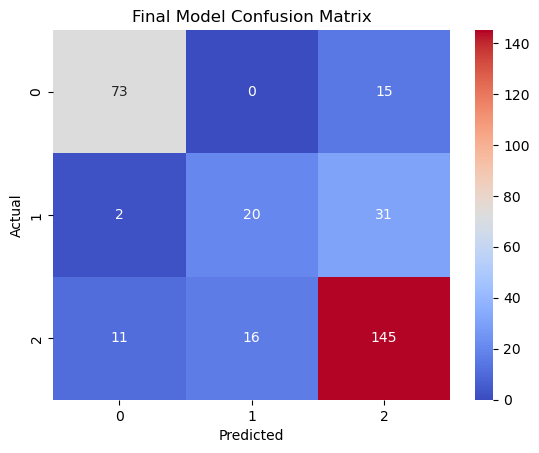

In [325]:
# Confusion Matrix
final_model = bag 
final_preds = final_model.predict(X_test_imputed)
sns.heatmap(confusion_matrix(y_test, final_preds), annot=True, fmt='d', cmap='coolwarm')
plt.title("Final Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Final Modeling Conclusion

After testing several classification models to predict track popularity, I decided that the **Bagging Classifier** was the best fit for this project. While the **Tuned Random Forest** technically had the highest overall **macro F1 score of 0.71 and accuracy of 0.79**, the Bagging model stood out the most to me. It was more accurate at predicting the most popular tracks, which was my primary focus. It hit an **F1 score of 0.80** for class 2, which gave me confidence in its ability to identify breakout hits.

The Bagging approach was resilient to noise and was stable across different data splits. Since the dataset includes a variety of musical features like tempo, danceability, loudness, and more. I needed a model that could handle that variability without overfitting. Bagging’s ability to reduce variance while still capturing meaningful patterns made it feel like the right choice for this kind of musical data.

I still explored other models including a **Decision Tree**, **Logistic Regression**, and a **Tuned Random Forest** and while each had its strengths, none matched the Bagging model’s performance on the most important class. The **Random Forest** was close, but it struggled a bit more with the mid-tier popularity tracks, and Logistic Regression simply didn’t hold up overall.

For Spotify, this model could be especially useful. It could help the platform better predict which tracks are likely to go viral, making early recommendations smarter and more impactful. That could support everything from playlist curation to marketing decisions and even help surface emerging artists faster.

